In [1]:
import os
from glob import glob
import random
import time
import tensorflow
import datetime
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # 3 = INFO, WARNING, and ERROR messages are not printed

from tqdm import tqdm

import numpy as np
import pandas as pd
from IPython.display import FileLink
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns 
%matplotlib inline
from IPython.display import display, Image
import matplotlib.image as mpimg
import cv2

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files       
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.metrics import log_loss

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import VGG16

## Import the Datasets

We will import the `.csv` file to read the labels.

In [2]:
dataset = pd.read_csv('../driver-dataset/driver_imgs_list.csv')
dataset.head(5)

,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


From the csv file, We'll use the `classname` as the labels for the images and use the image names to match the labels with the correct images.

## Convert image to grayscale and resize image to 64 * 64 pixels in 1 channel (grayscale)

In [3]:
NUMBER_CLASSES = 10
# Color type: 1 - grey, 3 - rgb

img_rows = 64
img_cols = 64
color_type = 1

def get_cv2_image(path, img_rows, img_cols, color_type=3):
    # Loading as Grayscale image
    if color_type == 1:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    # Reduce size
    img = cv2.resize(img, (img_rows, img_cols)) 
    return img



## Load train data and using the validation approach, split the train data into 80% and 20% 

In [4]:
# Training
def load_train(img_rows, img_cols, color_type=3):
    start_time = time.time()
    train_images = [] 
    train_labels = []
    # Loop over the training folder 
    for classed in tqdm(range(NUMBER_CLASSES)):
        print('Loading directory c{}'.format(classed))
        files = glob(os.path.join('../driver-dataset/imgs/', 'train', 'c' + str(classed), '*.jpg'))
        for file in files:
            img = get_cv2_image(file, img_rows, img_cols, color_type)
            train_images.append(img)
            train_labels.append(classed)
    print("Data Loaded in {} second".format(time.time() - start_time))
    return train_images, train_labels 

def read_and_normalize_train_data(img_rows, img_cols, color_type):
    X, labels = load_train(img_rows, img_cols, color_type)
    y = np_utils.to_categorical(labels, 10)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    
    return x_train, x_test, y_train, y_test

## Load validation/test data from the test folder consisting of 72989 images

In [5]:

# Validation
def load_test(size=200000, img_rows=64, img_cols=64, color_type=3):
    path = os.path.join('..', 'driver-dataset/imgs/test', '*.jpg')
    files = sorted(glob(path))
    X_test, X_test_id = [], []
    total = 0
    files_size = len(files)
    for file in tqdm(files):
        if total >= size or total >= files_size:
            break
        file_base = os.path.basename(file)
        img = get_cv2_image(file, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(file_base)
        total += 1
    return X_test, X_test_id

def read_and_normalize_sampled_test_data(size, img_rows, img_cols, color_type=3):
    test_data, test_ids = load_test(size, img_rows, img_cols, color_type)
    
    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(-1,img_rows,img_cols,color_type)
    
    return test_data, test_ids

In [6]:
x_train, x_test, y_train, y_test = read_and_normalize_train_data(img_rows, img_cols, color_type)
print('Train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]

Loading directory c0


 10%|████████▎                                                                          | 1/10 [00:08<01:19,  8.85s/it]

Loading directory c1


 20%|████████████████▌                                                                  | 2/10 [00:16<01:06,  8.33s/it]

Loading directory c2


 30%|████████████████████████▉                                                          | 3/10 [00:24<00:57,  8.25s/it]

Loading directory c3


 40%|█████████████████████████████████▏                                                 | 4/10 [00:33<00:49,  8.28s/it]

Loading directory c4


 50%|█████████████████████████████████████████▌                                         | 5/10 [00:41<00:41,  8.30s/it]

Loading directory c5


 60%|█████████████████████████████████████████████████▊                                 | 6/10 [00:50<00:33,  8.36s/it]

Loading directory c6


 70%|██████████████████████████████████████████████████████████                         | 7/10 [00:58<00:25,  8.37s/it]

Loading directory c7


 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [01:05<00:15,  8.00s/it]

Loading directory c8


 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [01:12<00:07,  7.63s/it]

Loading directory c9


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:20<00:00,  8.02s/it]

Data Loaded in 80.25355219841003 second
Train shape: (17939, 64, 64, 1)
17939 train samples


## Prepare data augmentation configuration

In [7]:
train_datagen = ImageDataGenerator(rescale = 1.0/255, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True, 
                                   validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale=1.0/ 255, validation_split = 0.2)

In [9]:
batch_size = 40
nb_train_samples = x_train.shape[0]
nb_validation_samples = x_test.shape[0]

print(nb_train_samples)
print(nb_validation_samples)
training_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
validation_generator = test_datagen.flow(x_test, y_test, batch_size=batch_size)

17939
4485


## Create a vanilla CNN model

#### Building the model

I'll develop the model with a total of 4 Convolutional layers, then a Flatten layer and then 2 Dense layers. I'll use the optimizer as `adam`, and loss as `categorical_crossentropy`.

In [10]:
!rm -f cnn_models/weights_best_vanilla.hdf5

'rm' is not recognized as an internal or external command,
operable program or batch file.


In [11]:
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
checkpointer = ModelCheckpoint(filepath='cnn_models/weights_best_vanilla.hdf5', 
                               monitor='val_loss', mode='min',
                               verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
callbacks = [checkpointer, es]

#### Model v1
---

In [12]:
def create_model_v1():
    # Vanilla CNN model
    model = Sequential()

    model.add(Conv2D(filters = 64, kernel_size = 3, padding='same', activation = 'relu', input_shape=(img_rows, img_cols, color_type)))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Conv2D(filters = 128, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Conv2D(filters = 256, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Conv2D(filters = 512, padding='same', kernel_size = 3, activation = 'relu'))
    model.add(MaxPooling2D(pool_size = 2))

    model.add(Dropout(0.5))

    model.add(Flatten())

    model.add(Dense(500, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation = 'softmax'))
    
    return model

In [13]:
model_v1 = create_model_v1()

# More details about the layers
model_v1.summary()

# Compiling the model
model_v1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 256)       295168    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 512)         1

In [14]:
# Training the Vanilla Model version 1
history_v1 = model_v1.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          callbacks=callbacks,
          epochs=3, batch_size=batch_size, verbose=1)

Epoch 1/3
449/449 [==============================] - ETA: 0s - loss: 1.5854 - accuracy: 0.5118
Epoch 00001: val_loss improved from inf to 0.29998, saving model to cnn_models\weights_best_vanilla.hdf5
449/449 [==============================] - 407s 907ms/step - loss: 1.5854 - accuracy: 0.5118 - val_loss: 0.3000 - val_accuracy: 0.9266
Epoch 2/3
449/449 [==============================] - ETA: 0s - loss: 0.3255 - accuracy: 0.8974
Epoch 00002: val_loss improved from 0.29998 to 0.08414, saving model to cnn_models\weights_best_vanilla.hdf5
449/449 [==============================] - 407s 906ms/step - loss: 0.3255 - accuracy: 0.8974 - val_loss: 0.0841 - val_accuracy: 0.9773
Epoch 3/3
449/449 [==============================] - ETA: 0s - loss: 0.1836 - accuracy: 0.9430
Epoch 00003: val_loss did not improve from 0.08414
449/449 [==============================] - 406s 904ms/step - loss: 0.1836 - accuracy: 0.9430 - val_loss: 0.0902 - val_accuracy: 0.9746


Load the classifier with the best validation loss

In [32]:
model_v1.load_weights('cnn_models/weights_best_vanilla.hdf5')

In [15]:
def plot_train_history(history):
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

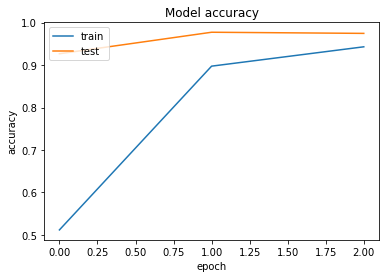

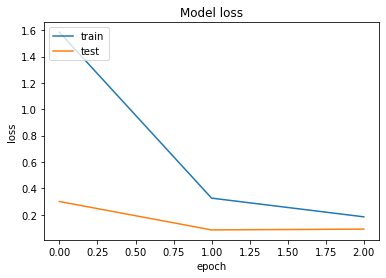

In [16]:
plot_train_history(history_v1)

In [17]:
def plot_test_class(model, test_files, image_number, color_type=1):
    img_brute = test_files[image_number]
    img_brute = cv2.resize(img_brute,(img_rows,img_cols))
    plt.imshow(img_brute, cmap='gray')

    new_img = img_brute.reshape(-1,img_rows,img_cols,color_type)

    y_prediction = model.predict(new_img, batch_size=batch_size, verbose=1)
    print('Y prediction: {}'.format(y_prediction))
    print('Predicted: {}'.format(activity_map.get('c{}'.format(np.argmax(y_prediction)))))
    
    plt.show()

In [18]:
score = model_v1.evaluate(x_test, y_test, verbose=1)
print('Score: ', score)

141/141 [==============================] - 27s 189ms/step - loss: 0.0902 - accuracy: 0.9746
Score:  [0.09019612520933151, 0.9745819568634033]


In [26]:
# Load the dataset previously downloaded from Kaggle
NUMBER_CLASSES = 10
# Color type: 1 - grey, 3 - rgb

def get_cv2_image(path, img_rows, img_cols, color_type=3):
    # Loading as Grayscale image
    if color_type == 1:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3:
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    # Reduce size
    img = cv2.resize(img, (img_rows, img_cols)) 
    return img

# Training
def load_train(img_rows, img_cols, color_type=3):
    start_time = time.time()
    train_images = [] 
    train_labels = []
    # Loop over the training folder 
    for classed in tqdm(range(NUMBER_CLASSES)):
        print('Loading directory c{}'.format(classed))
        files = glob(os.path.join('..', 'driver-dataset', 'imgs', 'train', 'c' + str(classed), '*.jpg'))
        for file in files:
            img = get_cv2_image(file, img_rows, img_cols, color_type)
            train_images.append(img)
            train_labels.append(classed)
    print("Data Loaded in {} second".format(time.time() - start_time))
    return train_images, train_labels 

def read_and_normalize_train_data(img_rows, img_cols, color_type):
    X, labels = load_train(img_rows, img_cols, color_type)
    y = np_utils.to_categorical(labels, 10)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1,img_rows,img_cols,color_type)
    
    return x_train, x_test, y_train, y_test

# Validation
def load_test(size=200000, img_rows=64, img_cols=64, color_type=3):
    path = os.path.join('..', 'driver-dataset', 'imgs', 'test', '*.jpg')
    files = sorted(glob(path))
    X_test, X_test_id = [], []
    total = 0
    files_size = len(files)
    for file in tqdm(files):
        if total >= size or total >= files_size:
            break
        file_base = os.path.basename(file)
        img = get_cv2_image(file, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(file_base)
        total += 1
    return X_test, X_test_id

def read_and_normalize_sampled_test_data(size, img_rows, img_cols, color_type=3):
    test_data, test_ids = load_test(size, img_rows, img_cols, color_type)
    
    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(-1,img_rows,img_cols,color_type)
    
    return test_data, test_ids

In [27]:
nb_test_samples = 200
test_files, test_targets = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, color_type)
print('Test shape:', test_files.shape)
print(test_files.shape[0], 'Test samples')

  0%|▏                                                                            | 200/79726 [00:00<03:29, 379.49it/s]

Test shape: (200, 64, 64, 1)
200 Test samples


In [29]:
activity_map = {'c0': 'Safe driving', 
                'c1': 'Texting - right', 
                'c2': 'Talking on the phone - right', 
                'c3': 'Texting - left', 
                'c4': 'Talking on the phone - left', 
                'c5': 'Operating the radio', 
                'c6': 'Drinking', 
                'c7': 'Reaching behind', 
                'c8': 'Hair and makeup', 
                'c9': 'Talking to passenger'}

1/1 [==============================] - 0s 999us/step
Y prediction: [[6.3471907e-01 5.8161160e-05 3.4798697e-01 1.5429034e-03 3.5814286e-05
  9.7135846e-05 3.9763195e-03 1.3920353e-05 9.8866718e-03 1.6830118e-03]]
Predicted: Safe driving


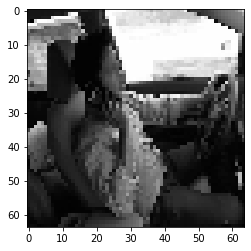

In [30]:
plot_test_class(model_v1, test_files, 20)

In [44]:
!rm -f cnn_models/weights_best_vanilla.hdf5

#### Optimised Vanilla CNN Model 

#### Model v2
---

In [33]:
def create_model_v2():
    # Optimised Vanilla CNN model
    model = Sequential()

    ## CNN 1
    model.add(Conv2D(32,(3,3),activation='relu',input_shape=(img_rows, img_cols, color_type)))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))

    ## CNN 2
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))

    ## CNN 3
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.5))

    ## Output
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10,activation='softmax'))

    return model

In [34]:
model_v2 = create_model_v2()

# More details about the layers
model_v2.summary()

# Compiling the model
model_v2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 62, 62, 32)        128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 31, 31, 64)       

In [36]:
# Training the optimized Vanilla Model
history_v2 = model_v2.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          callbacks=callbacks,
          epochs=3, batch_size=batch_size, verbose=1)

Epoch 1/3
449/449 [==============================] - ETA: 0s - loss: 1.4109 - accuracy: 0.5354
Epoch 00001: val_loss did not improve from 0.08414
449/449 [==============================] - 403s 898ms/step - loss: 1.4109 - accuracy: 0.5354 - val_loss: 0.2986 - val_accuracy: 0.9057
Epoch 2/3
449/449 [==============================] - ETA: 0s - loss: 0.3765 - accuracy: 0.8793
Epoch 00002: val_loss did not improve from 0.08414
449/449 [==============================] - 401s 892ms/step - loss: 0.3765 - accuracy: 0.8793 - val_loss: 0.1869 - val_accuracy: 0.9389
Epoch 3/3
449/449 [==============================] - ETA: 0s - loss: 0.2397 - accuracy: 0.9237
Epoch 00003: val_loss improved from 0.08414 to 0.07674, saving model to cnn_models\weights_best_vanilla.hdf5
449/449 [==============================] - 399s 889ms/step - loss: 0.2397 - accuracy: 0.9237 - val_loss: 0.0767 - val_accuracy: 0.9735


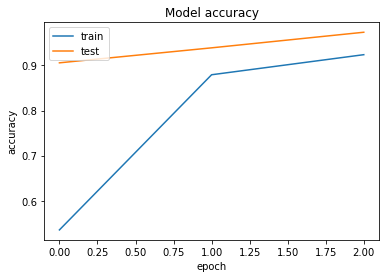

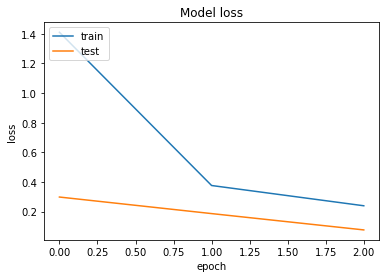

In [37]:
plot_train_history(history_v2)

In [38]:
score = model_v2.evaluate(x_test, y_test, verbose=1)
print('Score: ', score)

y_pred = model_v2.predict(x_test, batch_size=batch_size, verbose=1)
score = log_loss(y_test, y_pred)
print('Score log loss:', score)

141/141 [==============================] - 21s 146ms/step - loss: 0.0767 - accuracy: 0.9735
Score:  [0.07673557102680206, 0.9734671115875244]
113/113 [==============================] - 20s 179ms/step
Score log loss: 0.07673555168592071


1/1 [==============================] - 0s 986us/step
Y prediction: [[9.6531539e-07 1.7067508e-08 1.4679505e-06 2.1188528e-07 1.0552806e-05
  1.2607954e-04 2.0002315e-06 9.9966443e-01 1.9142871e-04 2.8064126e-06]]
Predicted: Reaching behind


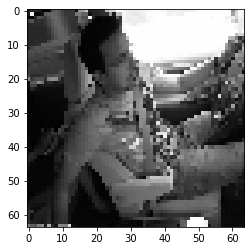

In [39]:
plot_test_class(model_v2, test_files, 101) # The model really performs badly

1/1 [==============================] - 0s 1ms/step
Y prediction: [[6.3655926e-07 7.7162660e-12 1.9143802e-09 2.4507398e-09 1.0113970e-05
  9.9699640e-01 4.3421469e-10 1.6878637e-08 2.6373569e-05 2.9664678e-03]]
Predicted: Operating the radio


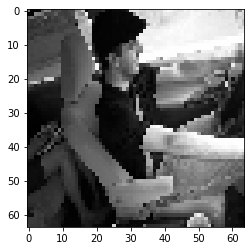

In [40]:
plot_test_class(model_v2, test_files, 1) # The model really performs badly

1/1 [==============================] - 0s 2ms/step
Y prediction: [[7.53806989e-06 1.43684912e-04 1.27951845e-08 9.99829531e-01
  1.46645561e-07 9.16295721e-06 8.98493635e-09 1.87827965e-07
  1.01478676e-07 9.47866465e-06]]
Predicted: Texting - left


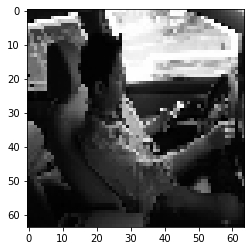

In [41]:
plot_test_class(model_v2, test_files, 143) 

## Create a vanilla CNN model with data augmentation

Here I'm augmenting the previous model `classifier`, I'll use the data on which I want to train the model. The folder `train` includes the images I need. I'll generate more images using **ImageDataGenerator** and split the training data into 80% train and 20% validation split.

In [ ]:
!rm -f cnn_models/weights_best_vanilla.hdf5

In [42]:
# Prepare data augmentation configuration
train_datagen = ImageDataGenerator(rescale = 1.0/255, 
                                   shear_range = 0.2, 
                                   zoom_range = 0.2, 
                                   horizontal_flip = True, 
                                   validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale=1.0/ 255, validation_split = 0.2)

In [43]:
nb_train_samples = x_train.shape[0]
nb_validation_samples = x_test.shape[0]
print(nb_train_samples)
print(nb_validation_samples)
training_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
validation_generator = test_datagen.flow(x_test, y_test, batch_size=batch_size)

17939
4485


#### Train the model with Data Augmentation

Using `fit_generator`, I'll train the model.

In [44]:
checkpoint = ModelCheckpoint(filepath='cnn_models/weights_best_vanilla.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history_v3 = model_v2.fit_generator(training_generator,
                         steps_per_epoch = nb_train_samples // batch_size,
                         epochs = 3, 
                         callbacks=[es, checkpoint],
                         verbose = 1,
                         validation_data = validation_generator,
                         validation_steps = nb_validation_samples // batch_size)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/3
448/448 [==============================] - 402s 898ms/step - loss: 1.1299 - accuracy: 0.6295 - val_loss: 34.5793 - val_accuracy: 0.0879
Epoch 2/3
448/448 [==============================] - 407s 909ms/step - loss: 0.6158 - accuracy: 0.7896 - val_loss: 0.7664 - val_accuracy: 0.7612
Epoch 3/3
448/448 [==============================] - 405s 904ms/step - loss: 0.5073 - accuracy: 0.8347 - val_loss: 0.2155 - val_accuracy: 0.9324


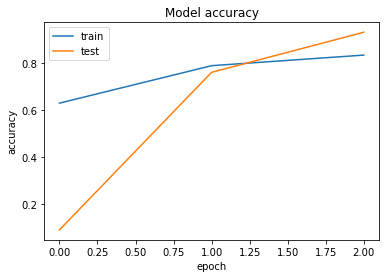

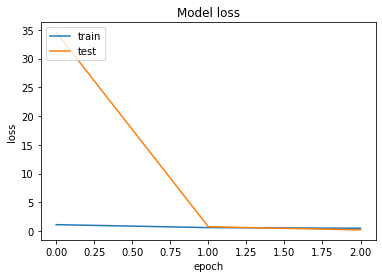

In [45]:
plot_train_history(history_v3)

In [46]:
# Evaluate the performance of the new model
score = model_v2.evaluate_generator(validation_generator, nb_validation_samples // batch_size)
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

Instructions for updating:
Please use Model.evaluate, which supports generators.
Test Score: 0.21560359001159668
Test Accuracy: 0.9323660731315613


1/1 [==============================] - 0s 998us/step
Y prediction: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Predicted: Operating the radio


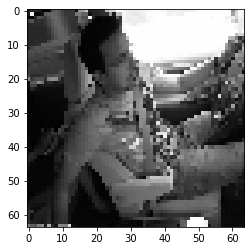

In [47]:
plot_test_class(model_v2, test_files, 101)

1/1 [==============================] - 0s 999us/step
Y prediction: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Predicted: Operating the radio


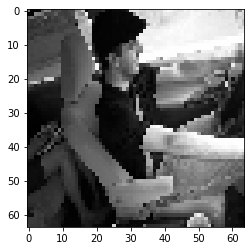

In [48]:
plot_test_class(model_v2, test_files, 1) 

1/1 [==============================] - 0s 999us/step
Y prediction: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Predicted: Operating the radio


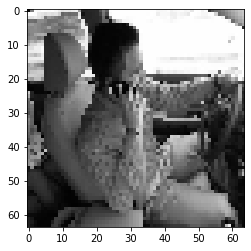

In [49]:
plot_test_class(model_v2, test_files, 145) 

1/1 [==============================] - 0s 1ms/step
Y prediction: [[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]
Predicted: Operating the radio


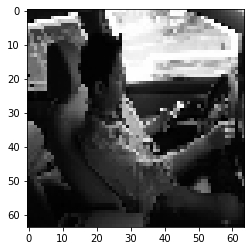

In [50]:
plot_test_class(model_v2, test_files, 143) 

The trained model achieved a validation accuracy of over 93%.